# Temperature prediction

# Introduction

In this project, a historical hourly weather dataset was used to develop models for temperature prediction. Two approaches were followed - batch learning and stream learning. Prior to problem development, the data was studied to check for imbalances and preprocessed to ensure data quality. Additionally, concept drift was checked. Various models were developed and several visualizations of the models performance and the data were presented. Overall, this project involved data analysis, preprocessing, and modeling to develop different temperature prediction models.

**Problem description** : The purpose of this project is to develop and test different temperature prediction models using a dataset that includes various variables such as pressure and humidity. We utilized regression techniques to develop these models and applied them to predict temperatures across different time ranges. It's important to note that due to the nature of temperature as a variable, certain values tend to repeat annually. For instance, temperatures are generally hotter in the summer and colder in the winter. However, temperatures usually remain relatively constant within each season, except for occasional variations. Despite this, there may be abrupt temperature spikes or drops in the distribution of temperature values. Additionally, it's worth noting that the dataset we used contains less data for the year 2012 than for the rest of the years. Through this project, we aimed to develop reliable temperature prediction models that take into account the various factors that affect temperature. The different techniques used and metrics to evaluate the performance of the development models are described below.

**Dataset** : https://www.kaggle.com/selfishgene/historical-hourly-weather-data

The Historical Hourly Weather Data dataset is a collection of hourly weather data for different cities around the world. The dataset includes information on temperature, humidity, pressure, wind direction, and speed, among other variables. The data was collected over several years (2012-2017), providing a rich source of information for climate modeling. The dataset is distributed along different CSV files containing the different features. 

One important field that makes this dataset suitable for stream learning is the "datetime" field. As the data is continuous (one datapoint each hour) it is certanly suitable for real-time processing. Also, as can be seen later, the data have concept drift (i.e : changes in data distribution over time). For this, models that are avaliable to adapt to changes in the distribution of the data over time are required. To simulate a more real scenario and as the dataset was quite large, it was divided into past and future data for the stream learning use-case. This was explained in more detail in the corresponding section. At last, the dataset needs some preparation and for the proposal project, most of the data was filtered and I focus the project on only one city. 


# First look through the data

First, lets read all the CSVs and treat them as an unique dataframe for more comfort. 

In [237]:
import pandas as pd

# Data was distributed along various files
cities = pd.read_csv("dataset/city_attributes.csv")
humidity = pd.read_csv("dataset/humidity.csv")
pressure = pd.read_csv("dataset/pressure.csv")
temperature = pd.read_csv("dataset/temperature.csv")
wind_direction = pd.read_csv("dataset/wind_direction.csv")
wind_speed = pd.read_csv("dataset/wind_speed.csv")
weather_description = pd.read_csv("dataset/weather_description.csv") 

df_list = [humidity, pressure, temperature, wind_direction, wind_speed]


Now, to differenciate the different columns, to each city name a token was added representing different features.
- H = Humidity
- P = Pressure
- T = Temperature
- WD = Wind Direction
- WS = Wind Speed

In [238]:
letters = iter(['H', 'P', 'T', 'WD', 'WS'])
index = 0
for df in df_list:
    letter = next(letters)
    column_mapping = {col: col + '_' + letter for col in humidity.columns[1:]}
    df_list[index] = df.rename(columns=column_mapping)
    index += 1

# Creating dataframes again from df_list
humidity, pressure, temperature, wind_direction, wind_speed = df_list

# Merging all csv files into one dataframe
df = pd.merge(humidity, pressure, on='datetime')
df = pd.merge(df, temperature, on='datetime')
df = pd.merge(df, wind_direction, on='datetime')
df = pd.merge(df, wind_speed, on='datetime')
df = df.merge(weather_description, on='datetime') 

print(df.shape)

(45253, 217)


In [239]:
df.head(5)

,datetime,Vancouver_H,Portland_H,San Francisco_H,Seattle_H,Los Angeles_H,San Diego_H,Las Vegas_H,Phoenix_H,Albuquerque_H,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,haze,NaN,NaN,NaN
1,2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,...,broken clouds,few clouds,overcast clouds,sky is clear,sky is clear,sky is clear,haze,sky is clear,sky is clear,sky is clear
2,2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,...,broken clouds,few clouds,sky is clear,few clouds,sky is clear,sky is clear,broken clouds,overcast clouds,sky is clear,overcast clouds
3,2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds
4,2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds


For a first approach, lets take just Los Angeles as our city to study.

In [240]:
# Filtering a city of interest
def getCityDataframe(city,df):
    filtered_df = df.filter(regex=f"^{city}")
    first_column = df.iloc[:, 0]
    filtered_df = pd.concat([first_column, filtered_df], axis=1)
    return filtered_df

df = getCityDataframe("Los Angeles", df)
df

,datetime,Los Angeles_H,Los Angeles_P,Los Angeles_T,Los Angeles_WD,Los Angeles_WS,Los Angeles
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,88.0,1013.0,291.870000,0.0,0.0,mist
2,2012-10-01 14:00:00,88.0,1013.0,291.868186,0.0,0.0,sky is clear
3,2012-10-01 15:00:00,88.0,1013.0,291.862844,0.0,0.0,sky is clear
4,2012-10-01 16:00:00,88.0,1013.0,291.857503,0.0,0.0,sky is clear
...,...,...,...,...,...,...,...
45248,2017-11-29 20:00:00,24.0,1016.0,293.550000,19.0,1.0,sky is clear
45249,2017-11-29 21:00:00,21.0,1016.0,295.680000,19.0,1.0,sky is clear
45250,2017-11-29 22:00:00,23.0,1015.0,295.960000,19.0,1.0,sky is clear
45251,2017-11-29 23:00:00,14.0,1016.0,295.650000,200.0,2.0,sky is clear


Feature extraction.

In [241]:
# Extract month, year and hour and add to the dataframe
df['datetime'] = pd.to_datetime(df['datetime'])

df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['hour'] = df['datetime'].dt.hour

df = df.drop(columns=['datetime'])
df.rename({'Los Angeles': 'weather_description'}, axis=1, inplace=True)

df

,Los Angeles_H,Los Angeles_P,Los Angeles_T,Los Angeles_WD,Los Angeles_WS,weather_description,month,year,hour
0,NaN,NaN,NaN,NaN,NaN,NaN,10,2012,12
1,88.0,1013.0,291.870000,0.0,0.0,mist,10,2012,13
2,88.0,1013.0,291.868186,0.0,0.0,sky is clear,10,2012,14
3,88.0,1013.0,291.862844,0.0,0.0,sky is clear,10,2012,15
4,88.0,1013.0,291.857503,0.0,0.0,sky is clear,10,2012,16
...,...,...,...,...,...,...,...,...,...
45248,24.0,1016.0,293.550000,19.0,1.0,sky is clear,11,2017,20
45249,21.0,1016.0,295.680000,19.0,1.0,sky is clear,11,2017,21
45250,23.0,1015.0,295.960000,19.0,1.0,sky is clear,11,2017,22
45251,14.0,1016.0,295.650000,200.0,2.0,sky is clear,11,2017,23


Drop Not a Number values.

In [242]:
df = df.dropna()
df

,Los Angeles_H,Los Angeles_P,Los Angeles_T,Los Angeles_WD,Los Angeles_WS,weather_description,month,year,hour
1,88.0,1013.0,291.870000,0.0,0.0,mist,10,2012,13
2,88.0,1013.0,291.868186,0.0,0.0,sky is clear,10,2012,14
3,88.0,1013.0,291.862844,0.0,0.0,sky is clear,10,2012,15
4,88.0,1013.0,291.857503,0.0,0.0,sky is clear,10,2012,16
5,88.0,1013.0,291.852162,0.0,0.0,sky is clear,10,2012,17
...,...,...,...,...,...,...,...,...,...
45248,24.0,1016.0,293.550000,19.0,1.0,sky is clear,11,2017,20
45249,21.0,1016.0,295.680000,19.0,1.0,sky is clear,11,2017,21
45250,23.0,1015.0,295.960000,19.0,1.0,sky is clear,11,2017,22
45251,14.0,1016.0,295.650000,200.0,2.0,sky is clear,11,2017,23


Check if the data is imbalanced

In [243]:
class_counts = df['year'].value_counts().sort_index()
print(class_counts)

2012    2132
2013    8499
2014    8751
2015    8757
2016    8781
2017    7991
Name: year, dtype: int64


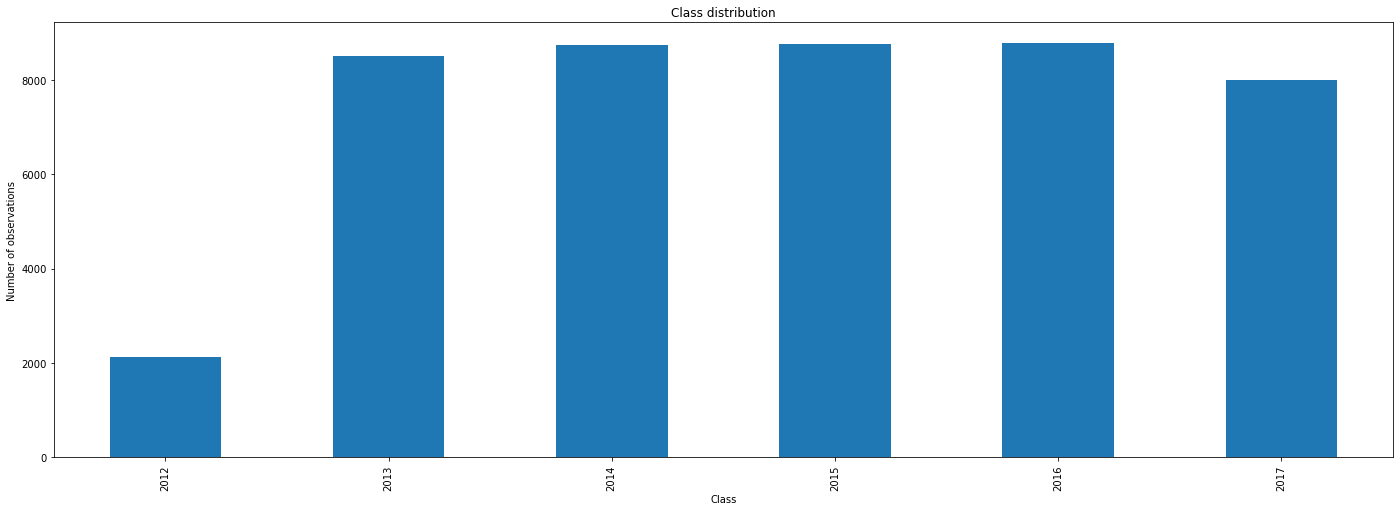

In [247]:
import matplotlib.pyplot as plt
class_counts.plot(kind='bar', figsize=(24,8))
plt.xlabel('Class')
plt.ylabel('Number of observations')
plt.title('Class distribution')

plt.show()

It can be seen that 2012 data is clearly imbalanced. For a first naive approach, I drop the 2012 data. The resulting dataframe is at follows.

In [248]:
df = df[df['year'] != 2012]
df.reset_index(drop=True, inplace=True)
df.index += 1
df

,Los Angeles_H,Los Angeles_P,Los Angeles_T,Los Angeles_WD,Los Angeles_WS,weather_description,month,year,hour
1,43.0,1014.0,283.06,0.0,2.0,sky is clear,1,2013,2
2,53.0,1016.0,281.97,0.0,0.0,sky is clear,1,2013,4
3,46.0,1016.0,281.89,0.0,0.0,sky is clear,1,2013,5
4,64.0,1017.0,280.04,127.0,0.0,scattered clouds,1,2013,6
5,52.0,1018.0,279.86,0.0,0.0,mist,1,2013,8
...,...,...,...,...,...,...,...,...,...
42775,24.0,1016.0,293.55,19.0,1.0,sky is clear,11,2017,20
42776,21.0,1016.0,295.68,19.0,1.0,sky is clear,11,2017,21
42777,23.0,1015.0,295.96,19.0,1.0,sky is clear,11,2017,22
42778,14.0,1016.0,295.65,200.0,2.0,sky is clear,11,2017,23


At the end, I rename the columns for convenience and save the resulting dataframe into a new CSV file.

In [249]:
# Renaming the columns before saving the new csv file
# TODO : Make a function to do this renaming without depending on the selected city
df.rename({'Los Angeles_H': 'humidity', 'Los Angeles_P': 'pressure', 'Los Angeles_T': 'temperature', 'Los Angeles_WD': 'wind_direction', 'Los Angeles_WS': 'wind_speed'}, axis=1, inplace=True)
df

/tmp/ipykernel_170340/4093786918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename({'Los Angeles_H': 'humidity', 'Los Angeles_P': 'pressure', 'Los Angeles_T': 'temperature', 'Los Angeles_WD': 'wind_direction', 'Los Angeles_WS': 'wind_speed'}, axis=1, inplace=True)


,humidity,pressure,temperature,wind_direction,wind_speed,weather_description,month,year,hour
1,43.0,1014.0,283.06,0.0,2.0,sky is clear,1,2013,2
2,53.0,1016.0,281.97,0.0,0.0,sky is clear,1,2013,4
3,46.0,1016.0,281.89,0.0,0.0,sky is clear,1,2013,5
4,64.0,1017.0,280.04,127.0,0.0,scattered clouds,1,2013,6
5,52.0,1018.0,279.86,0.0,0.0,mist,1,2013,8
...,...,...,...,...,...,...,...,...,...
42775,24.0,1016.0,293.55,19.0,1.0,sky is clear,11,2017,20
42776,21.0,1016.0,295.68,19.0,1.0,sky is clear,11,2017,21
42777,23.0,1015.0,295.96,19.0,1.0,sky is clear,11,2017,22
42778,14.0,1016.0,295.65,200.0,2.0,sky is clear,11,2017,23


In [250]:
# Saving resulting city info as a new dataset
df.to_csv('dataset.csv', index=False)

Some important points before continue. 
- Most of the values are int or float. In subsequently points, we are gonna see how standarization of this values influences the results.
- The weather description feature is a cathegorical variable that needs to be encoded. We are gonna see later how to apply One Hot Encoding to this feature to aggregate it into the model.
- New features were derived from the original data. Specifically, from datetime we extract month, year and hour features.

# Concept drift

Concept drift refers to the phenomenon where the statistical properties of a target variable that is being tried to predict from a data stream change over time (i.e : relationship of input features and output label may change as the distribution of the data evolves). When concept drift is present, classical machine learning models based on batches are not accurate and beging losing performance over time. Several concept drift detectors were included in River library, for this project, we analyze the distribution with two of them, ADWIN and PageHinkley. 

- **ADWIN** detector works by creating two different sliding data windows and monitoring the difference in the mean on them. As new datapoints are received in a data window, the mean is updated and the difference between means computed and, if that difference exceeds a certain threshold, the algorithm states that there is a change in data distribution. It is a good option to detect gradual changes in the mean, so it performs well to distributions that evolve slowly in time. 

- **PageHinkley** is a more simple detector that works nice on detecting sudden changes in the data distribution. It works monitoring the difference between mean of the new data and the mean of the previous historical data and, again, if it exceeds a certain threshold, signaling a change in the data distribution. 

So this is a good combination of detectors for detecting both gradual and sudden changes in the data distribution.

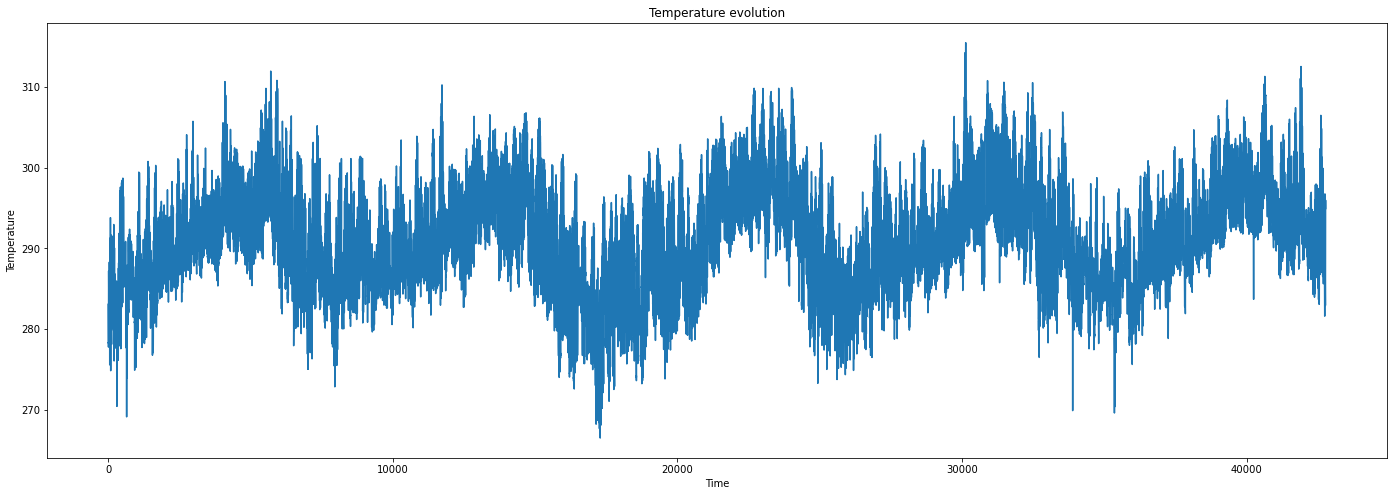

In [254]:
from river import stream,  compose, preprocessing, metrics, evaluate, tree
from river.tree import HoeffdingTreeClassifier
from matplotlib import pyplot as plt
import numpy as np

dataset_path = "dataset.csv"

#Data type conversion
dataset = stream.iter_csv(
    dataset_path, 
    converters = {
        'temperature': float, 
        'humidity':float, 
        'pressure':float, 
        'wind_direction':float, 
        'wind_speed':float, 
        'year': int, 
        'hour':int,
        'month':int
        },
    target='temperature'
    )
data = [(sample, target) for sample, target in dataset] # Storing fully in memory may not be the best solution and breaks a little the stream concept? 

# Plot temperatures evolution over years
temperatures = []
for sample, target in data:
    temperatures.append(target)
    
fig, ax = plt.subplots(figsize=(24, 8))
ax.plot(temperatures)

ax.set_title('Temperature evolution')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')

plt.show()

In [255]:
from matplotlib import gridspec

def plot_data(stream, drifts=None):
    fig = plt.figure(figsize=(24,8), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot()
    ax1.grid()
    ax1.plot(stream, label='Stream')
   
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red', linewidth=0.4)
    plt.show()

Lets check if there is any concept drift

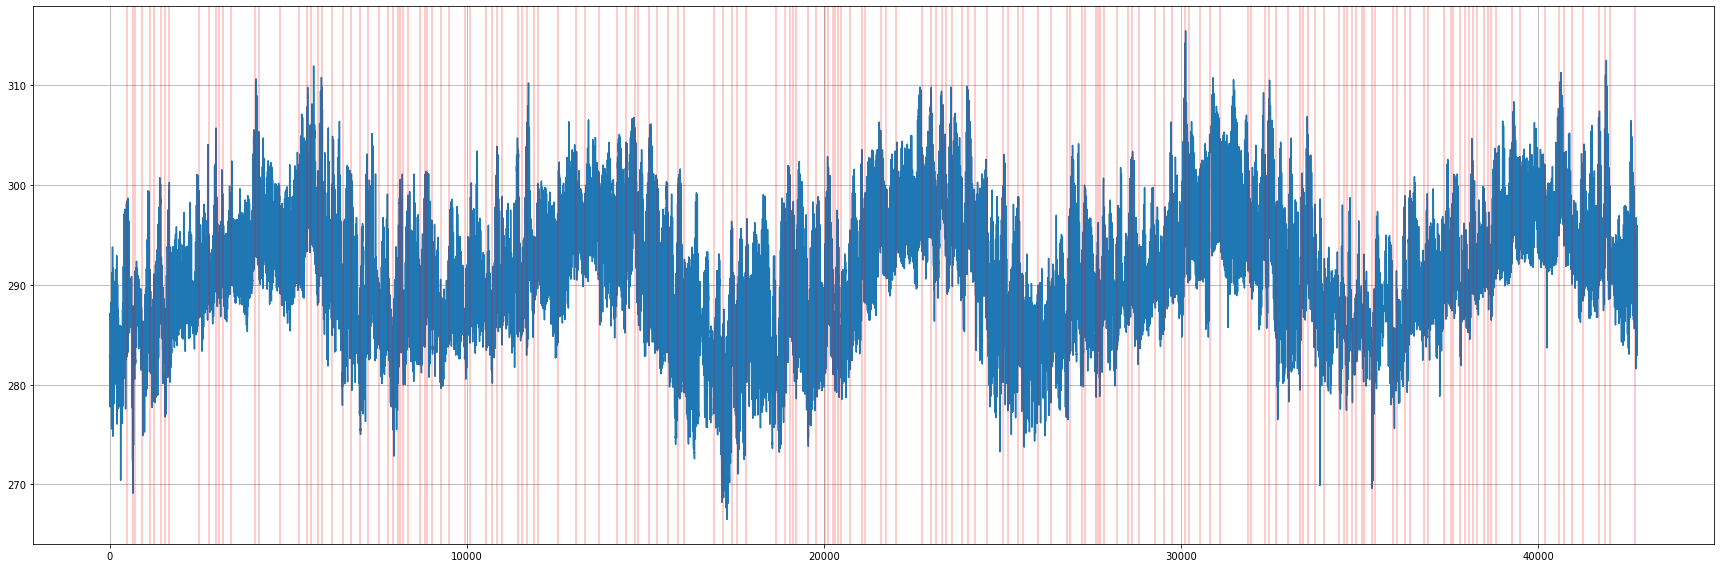

In [256]:
from river.drift import ADWIN

drift_detector = ADWIN()
drifts = []

for i, val in enumerate(temperatures):
    drift_detector.update(val)
    if drift_detector.drift_detected:        
        drifts.append(i)
        
plot_data(temperatures,drifts)

1023


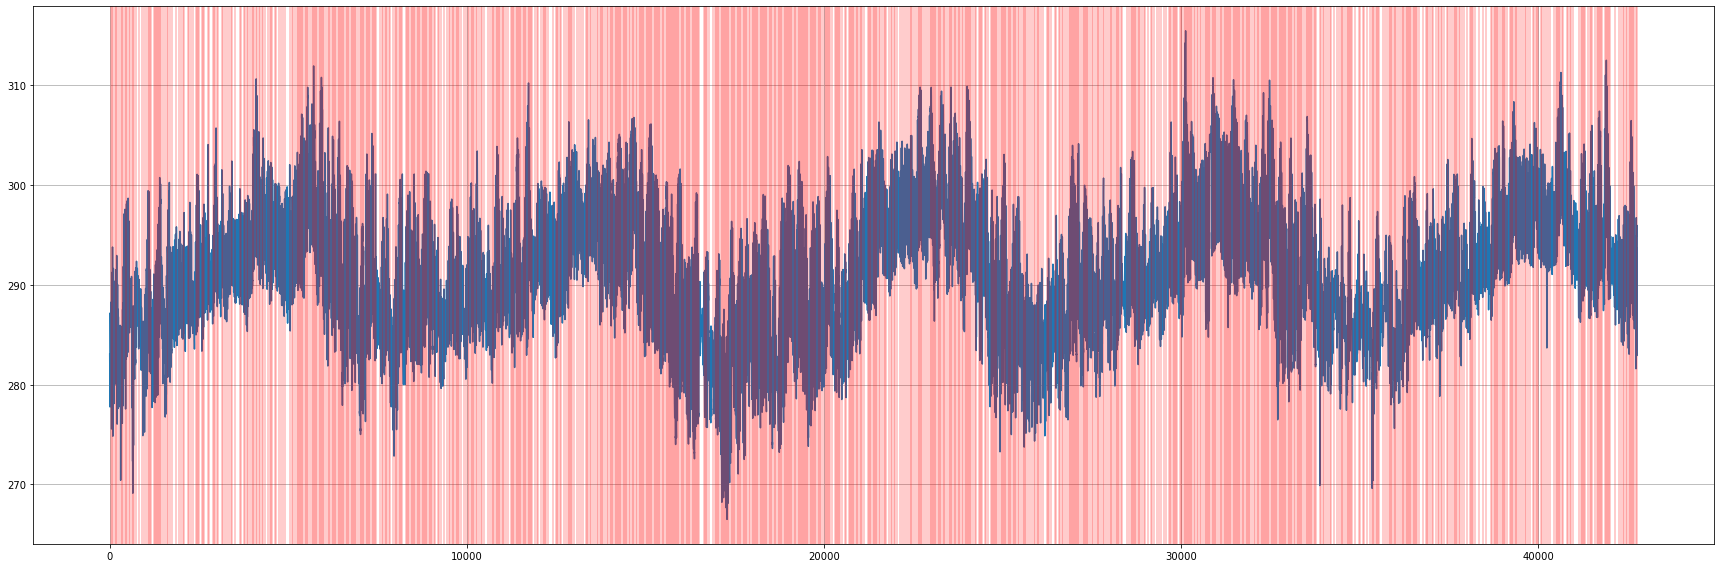

In [257]:
from river.drift import PageHinkley

drift_detector = PageHinkley()
drifts = []

for i, val in enumerate(temperatures):
    drift_detector.update(val)
    if drift_detector.drift_detected:
        drifts.append(i)

print(len(drifts))
plot_data(temperatures, drifts)


# Batch implementation

For a first batch-based implementation, lets start by making a few preprocessing steps. First, lets create a training and test set and separate temperature from the rest of the data as a feature and study the cardinality of each feature on the dataset.

In [258]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

df=pd.read_csv('dataset.csv')
train, test = train_test_split(df, test_size=0.2)

train.dropna(axis=0,subset=['temperature'],inplace=True)
y_train = train.temperature
train.drop(['temperature'],axis=1,inplace=True)
X = train

test.dropna(axis=0,subset=['temperature'],inplace=True)
y_test = test.temperature
test.drop(['temperature'],axis=1,inplace=True)
X_test = test

# Print features cardinality
print("Cardinality of features:")
for i in X.columns:
   print(f"{i} = {X[i].nunique()}")

Cardinality of features:
humidity = 96
pressure = 95
wind_direction = 361
wind_speed = 18
weather_description = 25
month = 12
year = 5
hour = 24


As said before, cathegorical columns needed to be encoded so we are going to use one-hot encoding for this purpose. One-hot encoding works by creating a new binary feature for each unique category in a categorical variable, but the main drawback it has it that increases a lot the size of the data being processed.

In [259]:
# Separating numerical and categorical columns
numerical_columns=[] 
categorical_columns=[]

for i in X.columns:
    if X[i].dtype in ["int64","float64"]:
        numerical_columns.append(i)
    else:
        categorical_columns.append(i)

print(f"Numerical columns: {numerical_columns}")        
print(f"Categorical columns: {categorical_columns}")        

Numerical columns: ['humidity', 'pressure', 'wind_direction', 'wind_speed', 'month', 'year', 'hour']
Categorical columns: ['weather_description']


In [260]:
c = ['weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_dust',
       'weather_description_few clouds', 'weather_description_fog',
       'weather_description_haze', 'weather_description_heavy intensity rain',
       'weather_description_light intensity drizzle',
       'weather_description_light intensity shower rain',
       'weather_description_light rain', 'weather_description_mist',
       'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_proximity shower rain',
       'weather_description_proximity thunderstorm',
       'weather_description_scattered clouds',
       'weather_description_shower rain', 'weather_description_sky is clear',
       'weather_description_smoke', 'weather_description_squalls',
       'weather_description_thunderstorm',
       'weather_description_thunderstorm with heavy rain',
       'weather_description_thunderstorm with light rain',
       'weather_description_thunderstorm with rain',
       'weather_description_very heavy rain']

In [261]:
from sklearn.preprocessing import OneHotEncoder

#One hot encoding for train

one_hot_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
encoded_X = pd.DataFrame(one_hot_encoder.fit_transform(X[categorical_columns]))

encoded_X.columns = one_hot_encoder.get_feature_names(categorical_columns)
X.drop(categorical_columns,axis=1,inplace=True)
encoded_X.index=X.index
X=pd.concat([X,encoded_X],axis=1)

# for test
encoded_X_test = pd.DataFrame(one_hot_encoder.transform(X_test[categorical_columns]))
X_test.drop(categorical_columns,axis=1,inplace=True)
encoded_X_test.columns = one_hot_encoder.get_feature_names(categorical_columns)
encoded_X_test.index=X_test.index
X_test=pd.concat([X_test,encoded_X_test],axis=1)
X_test


/home/kirle/bin/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/kirle/bin/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,humidity,pressure,wind_direction,wind_speed,month,year,hour,weather_description_broken clouds,weather_description_drizzle,weather_description_dust,...,weather_description_scattered clouds,weather_description_shower rain,weather_description_sky is clear,weather_description_smoke,weather_description_squalls,weather_description_thunderstorm,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
17661,41.0,1036.0,153.0,0.0,1,2015,3,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42138,67.0,1019.0,31.0,0.0,11,2017,8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762,67.0,1022.0,0.0,0.0,2,2013,7,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9796,72.0,1014.0,0.0,0.0,2,2014,3,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16101,76.0,1028.0,166.0,1.0,11,2014,3,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,39.0,1026.0,0.0,0.0,1,2013,20,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31555,83.0,1013.0,137.0,0.0,8,2016,7,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23953,68.0,1017.0,61.0,0.0,10,2015,7,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32994,100.0,960.0,45.0,0.0,10,2016,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we can study the performance of different simple models.

In [262]:
# Separate train and validation splits
X, X_valid,y_train,y_valid = train_test_split(X,y_train,train_size=0.8,test_size=0.2)

In [263]:
# Lets try a simple linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X,y_train)
predictions=model.predict(X_valid)
score_valid=mean_absolute_error(y_valid,predictions)
print("MAE: ",score_valid)

MAE:  4.0737977321738255


Linear regression is not so good. Lets compare its performance with another common regression models, using also a cross validation approach.
Scorers can be checked in: https://scikit-learn.org/stable/modules/model_evaluation.html

In [264]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

mean_scores = []
for model in models:
    scores = cross_val_score(model, X, y_train, cv=5, scoring='neg_mean_absolute_error')
    mean_score = -scores.mean()
    print(f"{type(model).__name__} --> MAE = {mean_score}")
    mean_scores.append(mean_score)    

LinearRegression --> MAE = 4.121646455581239
DecisionTreeRegressor --> MAE = 2.06034098049227
RandomForestRegressor --> MAE = 1.5433812202586725
GradientBoostingRegressor --> MAE = 2.0699001040381133


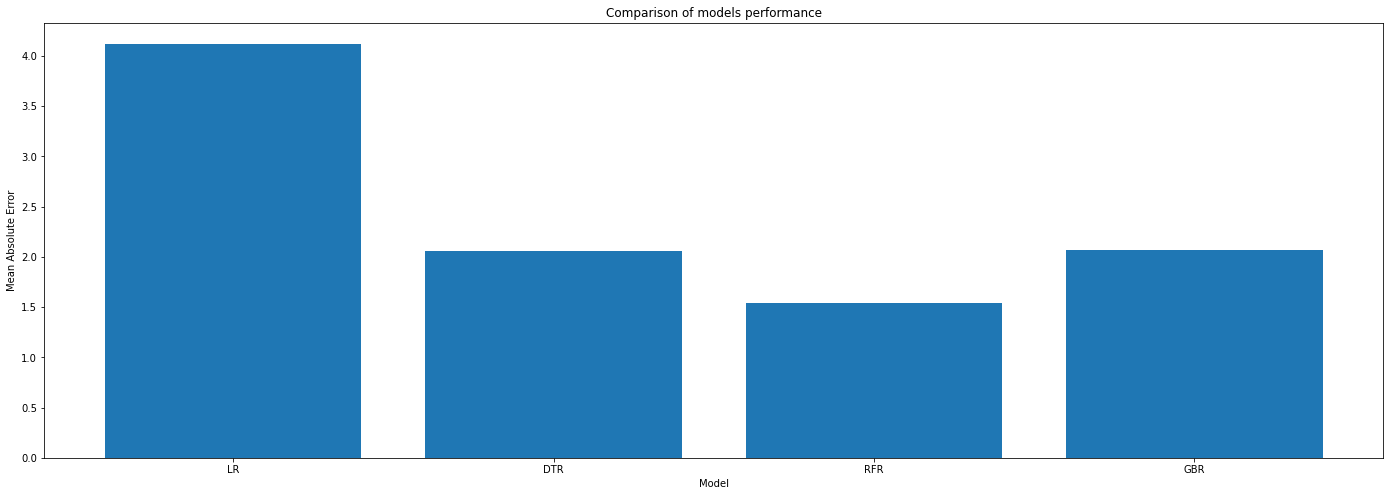

In [268]:
fig, ax = plt.subplots(figsize=(24, 8))

ax.bar(["LR", "DTR", "RFR", "GBR"], mean_scores)
ax.set_xlabel('Model')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Comparison of models performance')


plt.show()

Looking at the results, it seems that Random Forest is the one that performs better, lets now look on how to do this with a stream learning approach.

# Stream learning

As a first approach, all data was converted to a stream and passed through a stream learning pipeline. Lets first take a look to a Linear Regression simple model and how it works:

In [269]:
from river import preprocessing
from river import compose
from river import linear_model
from river import linear_model, metrics, preprocessing, optim, utils
import pandas as pd
from river import stream

# Loading the data
df=pd.read_csv('dataset.csv')
df.dropna(axis=0,subset=['temperature'],inplace=True)

X = df 
y = df.pop('temperature')

# Prepare the model
model = compose.Select('weather_description') | preprocessing.OneHotEncoder(sparse="True")
model |= compose.Discard('weather_description')
model |= preprocessing.StandardScaler() 
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.000001))

metric = utils.Rolling(metrics.MAE(),1)
metric2 = utils.Rolling(metrics.MSE(),1)

for xi,yi in stream.iter_pandas(X, y):
    y_pred = model.predict_one(xi)
    model.learn_one(xi, yi)
    metric.update(yi, y_pred)
    metric2.update(yi, y_pred)
    
print(f'MAE: {metric.get()}')
print(f'MSE: {metric2.get()}')

MAE: 5.2672970395637435
MSE: 27.744418102996978


Again, it seems to work better without scaling the features and just scaling the target. Lets try again doing exactly the same without scaling the features:

In [270]:
from river import linear_model
from river.linear_model import LinearRegression
from river.compose import Pipeline
from river import optim
from river.preprocessing import OneHotEncoder, TargetStandardScaler

dataset = stream.iter_csv(
    "dataset.csv", 
    converters = {
        'temperature': float, 
        'humidity':float, 
        'pressure':float, 
        'wind_direction':float, 
        'wind_speed':float, 
        'year': int, 
        'hour':int,
        'month':int
        },
    target='temperature'
    )
data = [(sample, target) for sample, target in dataset] # Storing fully in memory may not be the best solution and breaks a little the stream concept? 


optimizer=optim.SGD(0.001)
model = Pipeline(
    OneHotEncoder('weather_description'),
    linear_model.LinearRegression(optimizer=optimizer)
)

model = preprocessing.TargetStandardScaler(regressor=model)

metric = utils.Rolling(metrics.MAE(),1)
metric2 = utils.Rolling(metrics.MSE(),1)

print(evaluate.progressive_val_score(data, model, metric))
print(evaluate.progressive_val_score(data, model, metric2))

MAE: 0.962544
MSE: 0.979805


Nice error. Now lets simulate a real scenario dividing the dataset into two streams of data. 
- The first stream will correspond to **the past**. We will use this data to train the model.
- The second period will be **the future**. We will fed the model with new data and update the model accordingly. 

First the model was trained using all past data, and later on each datapoint was pased to the model, that makes a new prediction on how the temperature will be on the next hour. Then a delay of an hour is simulated and new measures were passed to the model, that computes the error between the previous prediction and the actual true value and performs a new prediction for the new hour. This process was repeated until there is no new data incoming.

The present time starts at January 1 of 2017, and is represented with a red line in the next graphic:

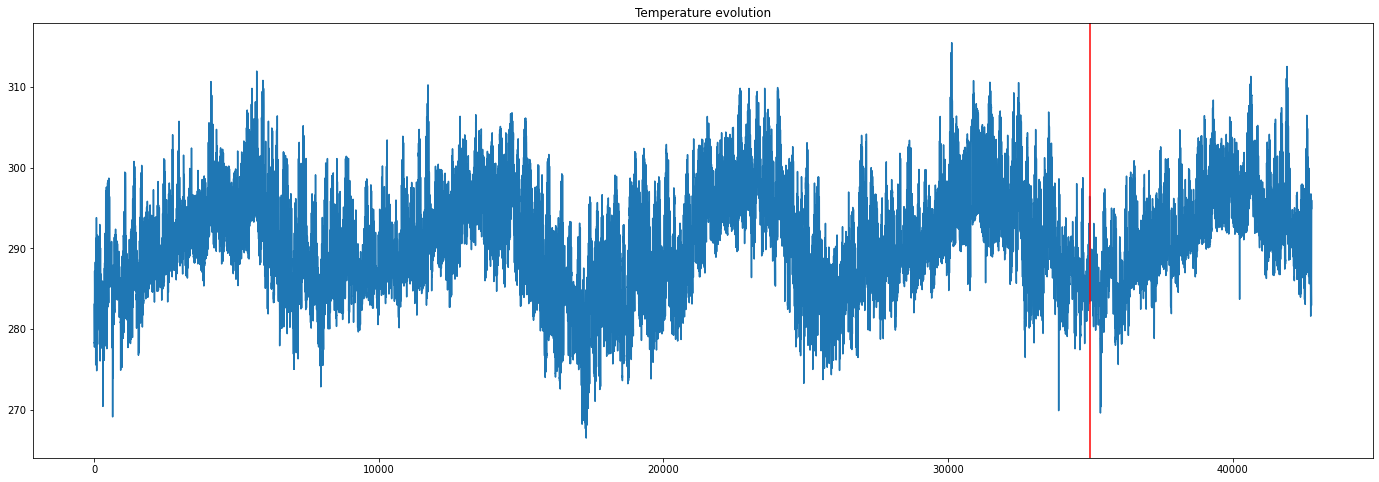

In [273]:
temperatures = []
for sample, target in data:
    temperatures.append(target)

fig, ax = plt.subplots(figsize=(24, 8))
ax.plot(temperatures)
ax.axvline(x=35000, color='r')
ax.set_title('Temperature evolution')
plt.show()

### Linear Regressor

In [274]:
from river import linear_model
from river.linear_model import LinearRegression
from river.compose import Pipeline
from river import optim
from river.preprocessing import OneHotEncoder, TargetStandardScaler

# Loading the data
dataset = stream.iter_csv(
    "dataset.csv", 
    converters = {
        'temperature': float, 
        'humidity':float, 
        'pressure':float, 
        'wind_direction':float, 
        'wind_speed':float, 
        'year': int, 
        'hour':int,
        'month':int
        },
    target='temperature'
    )
data = [(sample, target) for sample, target in dataset] # Storing fully in memory may not be the best solution and breaks a little the stream concept? 

# Preparing the model
optimizer=optim.SGD(0.001)
model = Pipeline(
    OneHotEncoder('weather_description'),
    linear_model.LinearRegression(optimizer=optimizer)
)

model = preprocessing.TargetStandardScaler(regressor=model)


# Training simulation a past data and a present stream

past_data_pred_y = []
past_data_true_y = []
# Past
for xi, yi in data[:35000]:
    y_pred = model.predict_one(xi)
    model.learn_one(xi, yi)
    # metric.update(xi,y_pred)
    past_data_pred_y.append(y_pred)
    past_data_true_y.append(yi)
    
# Present
stream_data = iter(data[35000:])
predicted_y = []
true_y = []
prev_xi, prev_yi = data[35000][0],data[35000][1]
for xi, yi in stream_data:
    try:
        y_pred = model.predict_one(xi) # Actual prediction for the next hour
        print(f"( {xi['year']}-{xi['month']} | {xi['hour']}:00 ) : Predicted temperature for next hour: {y_pred}")
        next_xi, next_yi = next(stream_data) # True temperature for the next hour
        print(f"( {xi['year']}-{xi['month']} | {xi['hour']}:00 ) : Actual temperature after one hour: {next_yi}")
        model.learn_one(xi, yi) 
        prev_xi, prev_yi = xi, yi 
        
        predicted_y.append(y_pred)
        true_y.append(next_yi)
        
    except StopIteration as err:
        print("End of data")
        break

( 2017-1 | 20:00 ) : Predicted temperature for next hour: 291.66695544522935
( 2017-1 | 20:00 ) : Actual temperature after one hour: 287.88
( 2017-1 | 22:00 ) : Predicted temperature for next hour: 292.8060267365301
( 2017-1 | 22:00 ) : Actual temperature after one hour: 289.21
( 2017-1 | 0:00 ) : Predicted temperature for next hour: 291.26248453733484
( 2017-1 | 0:00 ) : Actual temperature after one hour: 288.88
( 2017-1 | 2:00 ) : Predicted temperature for next hour: 288.99681493273715
( 2017-1 | 2:00 ) : Actual temperature after one hour: 287.0
( 2017-1 | 4:00 ) : Predicted temperature for next hour: 286.4929830834407
( 2017-1 | 4:00 ) : Actual temperature after one hour: 286.27
( 2017-1 | 6:00 ) : Predicted temperature for next hour: 285.8034619644098
( 2017-1 | 6:00 ) : Actual temperature after one hour: 285.89
( 2017-1 | 8:00 ) : Predicted temperature for next hour: 284.28773883627423
( 2017-1 | 8:00 ) : Actual temperature after one hour: 285.23
( 2017-1 | 10:00 ) : Predicted tem

Lets use again Mean Absolute Error and Mean Square Error as metrics to compute the model's performance. The results can be seen below:

In [275]:
from river import metrics

mae = utils.Rolling(metrics.MAE(),1)
mse = utils.Rolling(metrics.MSE(),1)

for y_pred, y_true in zip(predicted_y, true_y):
    mae.update(y_true, y_pred)
    mse.update(y_true, y_pred)

print(f"MAE: {mae.get()}")
print(f"MSE: {mse.get()}")


MAE: 0.6330003233659909
MSE: 0.40068940938144904


Performance plots are given below.

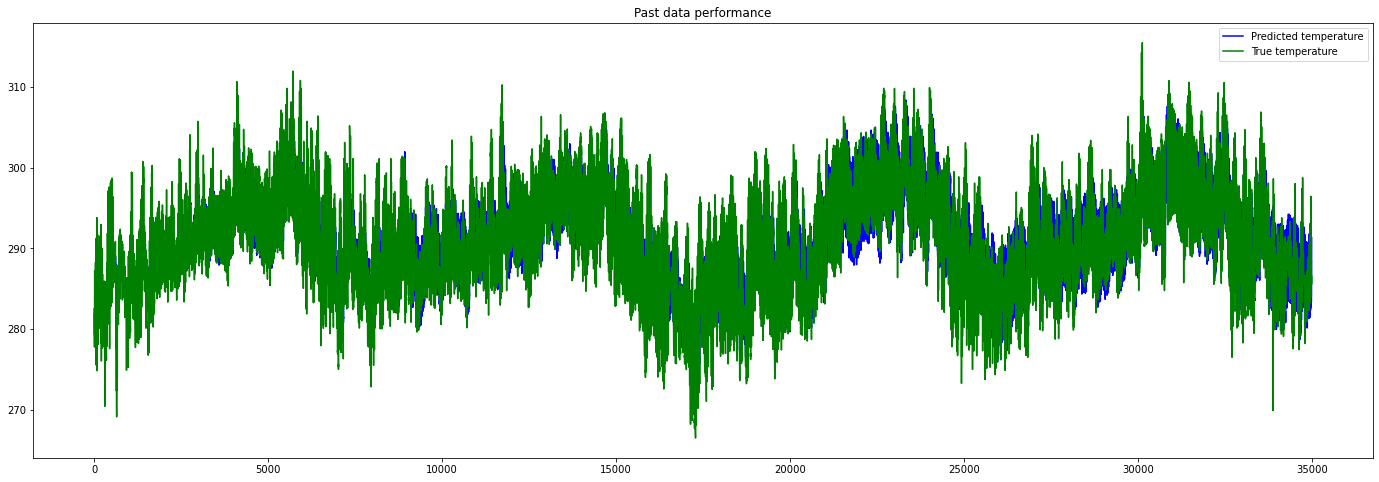

In [277]:
# Past data performance
past_data_pred_y = past_data_pred_y[1:]
past_data_true_y = past_data_true_y[1:]
plt.figure(figsize=(24, 8))
plt.plot(np.array(past_data_pred_y), color='blue', label='Predicted temperature')
plt.plot(np.array(past_data_true_y), color='green', label='True temperature')
plt.title("Past data performance")
plt.legend()
plt.show()

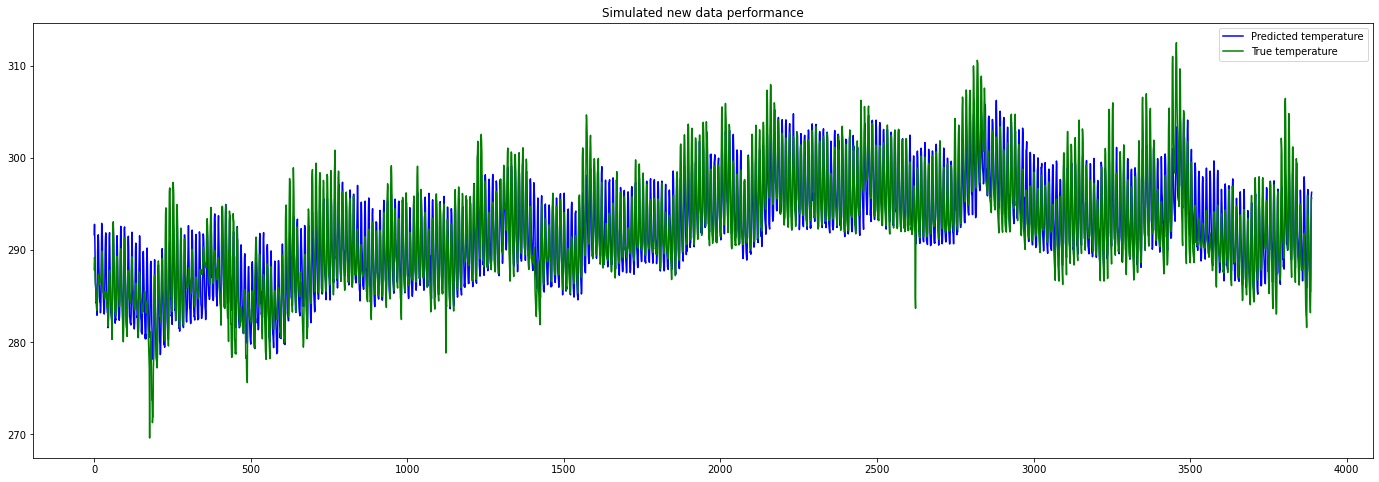

In [278]:
# New data performance
plt.figure(figsize=(24, 8))
plt.plot(np.array(predicted_y), color='blue', label='Predicted temperature')
plt.plot(np.array(true_y), color='green', label='True temperature')
plt.title("Simulated new data performance")
plt.legend()
plt.show()


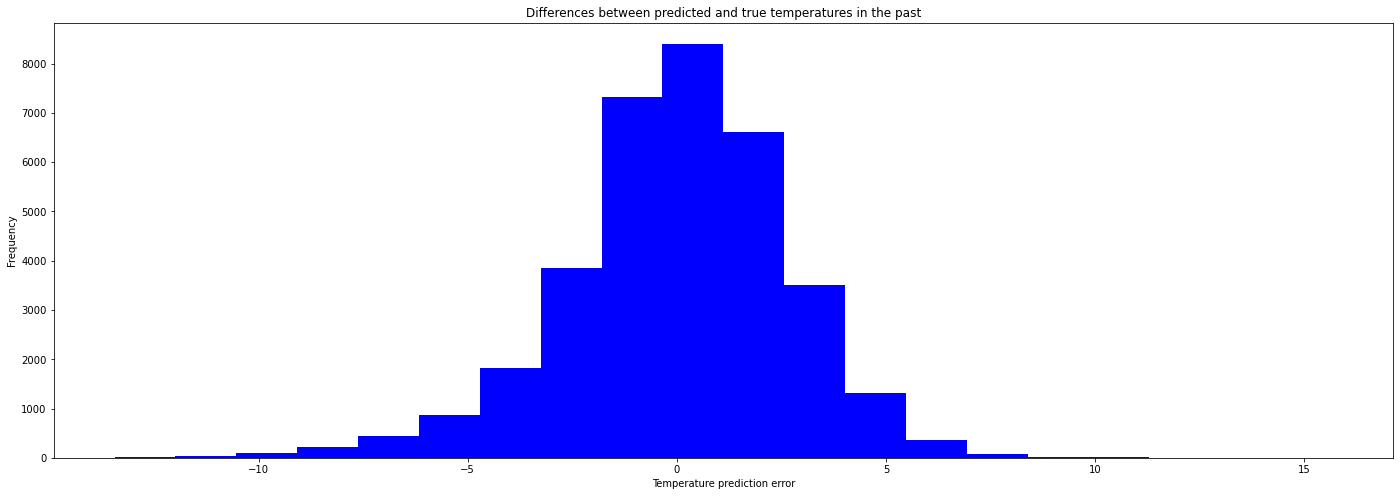

In [279]:
past_data_pred_y = past_data_pred_y[1:]
past_data_true_y = past_data_true_y[1:]

differences = np.array(past_data_pred_y) - np.array(past_data_true_y)

plt.figure(figsize=(24, 8))
plt.hist(differences, bins=20, color='blue')
plt.xlabel("Temperature prediction error")
plt.ylabel("Frequency")
plt.title("Differences between predicted and true temperatures in the past")
plt.show()

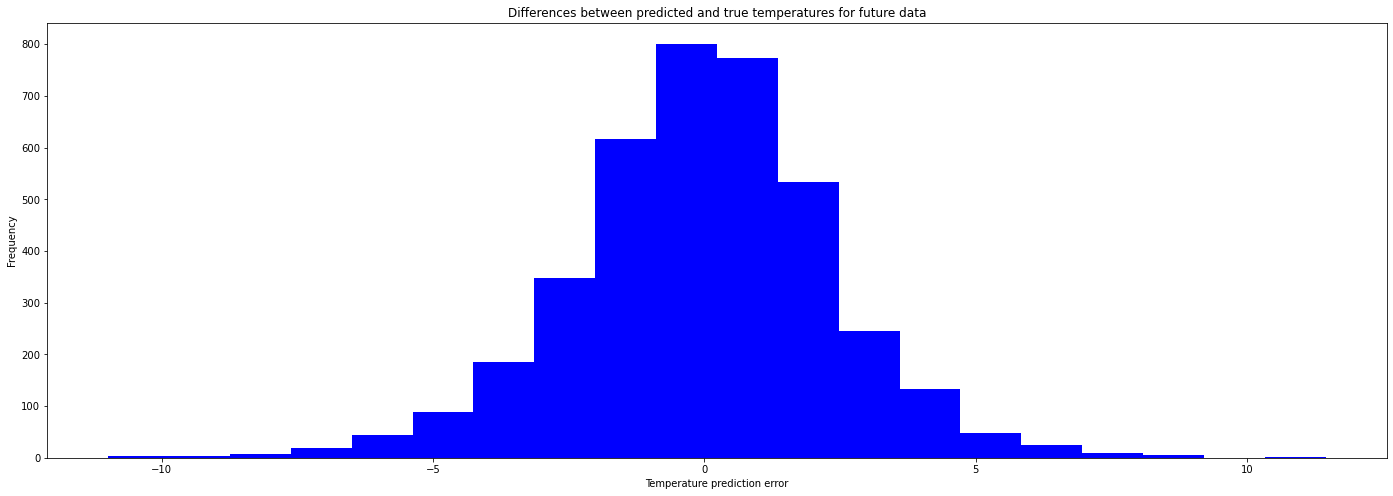

In [280]:
differences = np.array(predicted_y) - np.array(true_y)

plt.figure(figsize=(24, 8))
plt.hist(differences, bins=20, color='blue')
plt.xlabel("Temperature prediction error")
plt.ylabel("Frequency")
plt.title("Differences between predicted and true temperatures for future data")
plt.show()

In [281]:
# Save results for later plot
past_data_pred_y1 = past_data_pred_y[1:]
past_data_true_y1 = past_data_true_y[1:]
future_data_pred_y1 = predicted_y
future_data_true_y1 = true_y

While the model is not so accurate, it present valid results for a first approach. Lets try with another two regression models to see the difference.

I will use:

- K-nearest neighbours regressor.
- HoeffdingTreeRegressor

### KNN Regressor

In [282]:
from river.compose import Pipeline
from river import optim
from river.preprocessing import OneHotEncoder
from river import neighbors
# Loading the data
dataset = stream.iter_csv(
    "dataset.csv", 
    converters = {
        'temperature': float, 
        'humidity':float, 
        'pressure':float, 
        'wind_direction':float, 
        'wind_speed':float, 
        'year': int, 
        'hour':int,
        'month':int
        },
    target='temperature'
    )
data = [(sample, target) for sample, target in dataset] # Storing fully in memory may not be the best solution and breaks a little the stream concept? 

# Preparing the model
model = Pipeline(
    OneHotEncoder('weather_description'),
    
    neighbors.KNNRegressor()
)

model = preprocessing.TargetStandardScaler(regressor=model)


# Training simulation a past data and a present stream

past_data_pred_y = []
past_data_true_y = []
# Past
for xi, yi in data[:35000]:
    y_pred = model.predict_one(xi)
    model.learn_one(xi, yi)
    # metric.update(xi,y_pred)
    past_data_pred_y.append(y_pred)
    past_data_true_y.append(yi)
    
# Present
stream_data = iter(data[35000:])
predicted_y = []
true_y = []
prev_xi, prev_yi = data[35000][0],data[35000][1]
for xi, yi in stream_data:
    try:
        y_pred = model.predict_one(xi) # Actual prediction for the next hour
        print(f"( {xi['year']}-{xi['month']} | {xi['hour']}:00 ) : Predicted temperature for next hour: {y_pred}")
        next_xi, next_yi = next(stream_data) # True temperature for the next hour
        print(f"( {xi['year']}-{xi['month']} | {xi['hour']}:00 ) : Actual temperature after one hour: {next_yi}")
        model.learn_one(xi, yi) 
        prev_xi, prev_yi = xi, yi 
        
        predicted_y.append(y_pred)
        true_y.append(next_yi)
        
    except StopIteration as err:
        print("End of data")
        break

( 2017-1 | 20:00 ) : Predicted temperature for next hour: 284.10690962097584
( 2017-1 | 20:00 ) : Actual temperature after one hour: 287.88
( 2017-1 | 22:00 ) : Predicted temperature for next hour: 283.37967664128263
( 2017-1 | 22:00 ) : Actual temperature after one hour: 289.21
( 2017-1 | 0:00 ) : Predicted temperature for next hour: 287.06884372186755
( 2017-1 | 0:00 ) : Actual temperature after one hour: 288.88
( 2017-1 | 2:00 ) : Predicted temperature for next hour: 283.79682915323514
( 2017-1 | 2:00 ) : Actual temperature after one hour: 287.0
( 2017-1 | 4:00 ) : Predicted temperature for next hour: 282.39409494230335
( 2017-1 | 4:00 ) : Actual temperature after one hour: 286.27
( 2017-1 | 6:00 ) : Predicted temperature for next hour: 284.346624602447
( 2017-1 | 6:00 ) : Actual temperature after one hour: 285.89
( 2017-1 | 8:00 ) : Predicted temperature for next hour: 283.0945051524558
( 2017-1 | 8:00 ) : Actual temperature after one hour: 285.23
( 2017-1 | 10:00 ) : Predicted tem

In [283]:
from river import metrics
mae = utils.Rolling(metrics.MAE(),1)
mse = utils.Rolling(metrics.MSE(),1)

for y_pred, y_true in zip(predicted_y, true_y):
    mae.update(y_true, y_pred)
    mse.update(y_true, y_pred)

print(f"MAE: {mae.get()}")
print(f"MSE: {mse.get()}")


MAE: 2.0204905854192248
MSE: 4.082382205767722


K-nearest neigbours seems to be more computational expensive than Linear Regression, but also achieves quite worse results. Lets see the performance resuls in a graph.

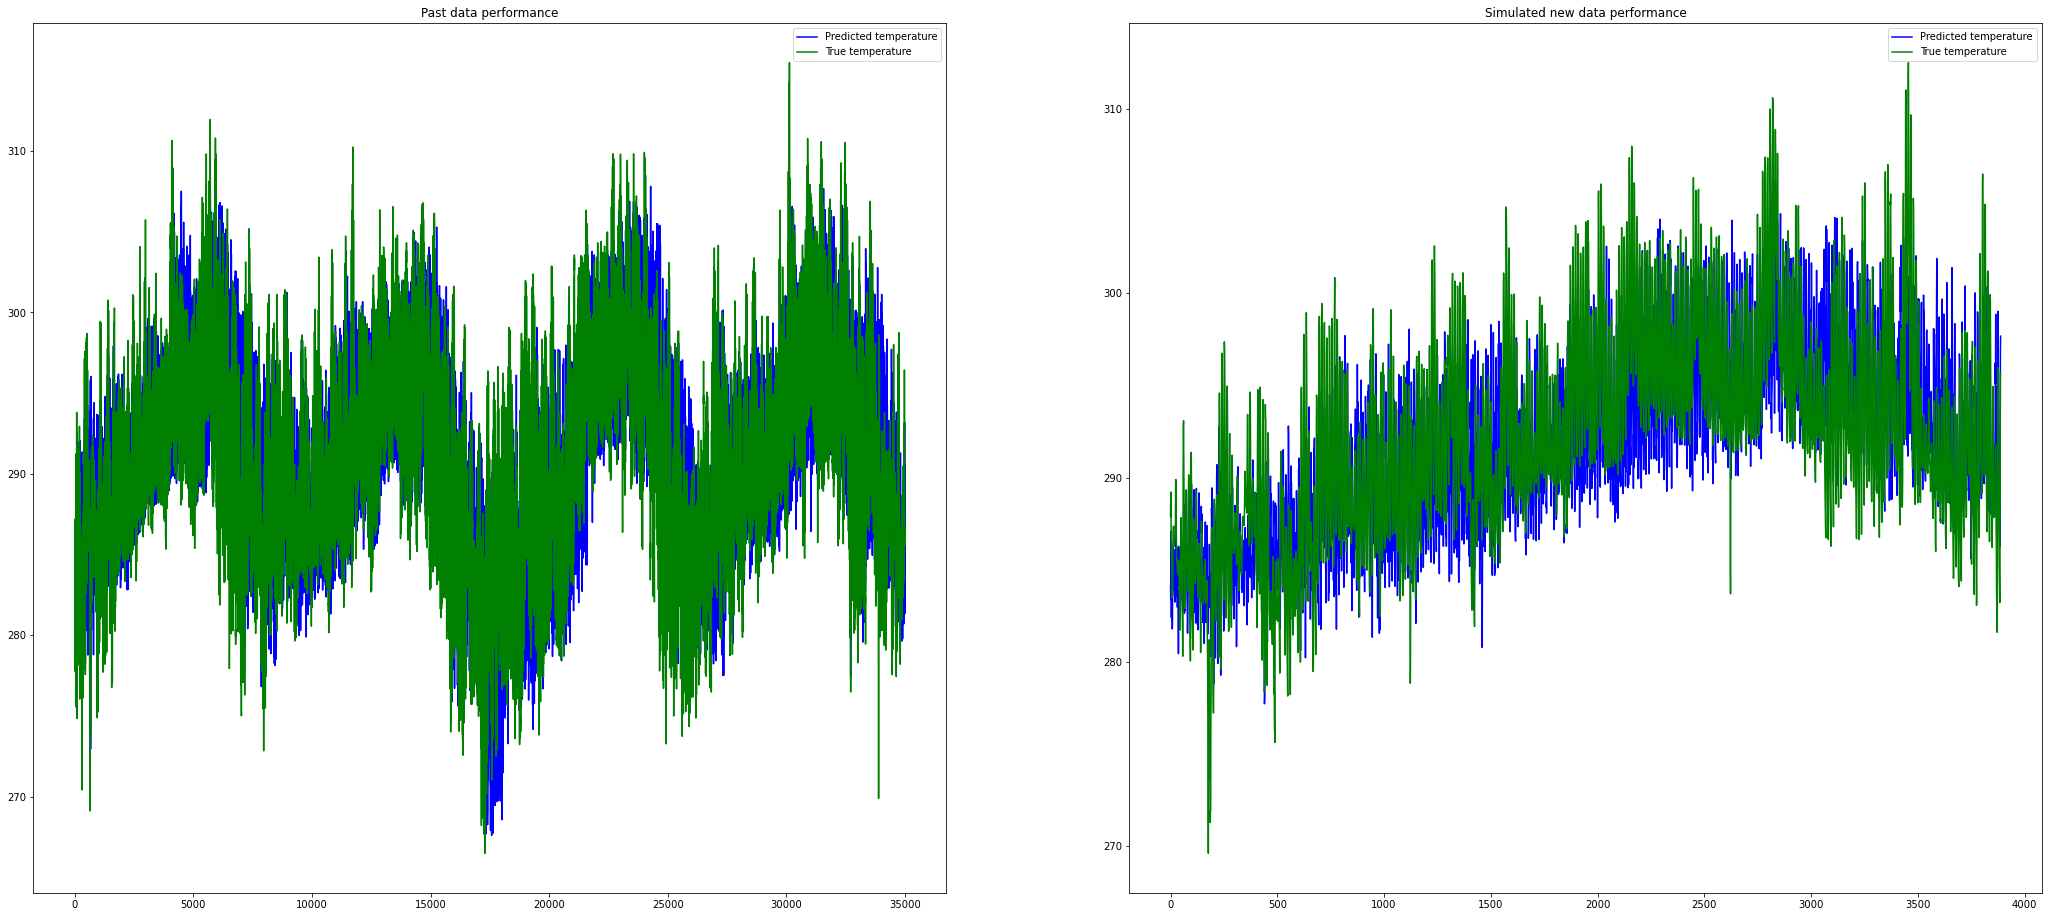

In [284]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(36, 16))
# Past
past_data_pred_y = past_data_pred_y[1:]
past_data_true_y = past_data_true_y[1:]
axes[0].plot(np.array(past_data_pred_y), color='blue', label='Predicted temperature')
axes[0].plot(np.array(past_data_true_y), color='green', label='True temperature')
axes[0].set_title("Past data performance")
axes[0].legend()
# Future
axes[1].plot(np.array(predicted_y), color='blue', label='Predicted temperature')
axes[1].plot(np.array(true_y), color='green', label='True temperature')
axes[1].set_title("Simulated new data performance")
axes[1].legend()

plt.show()

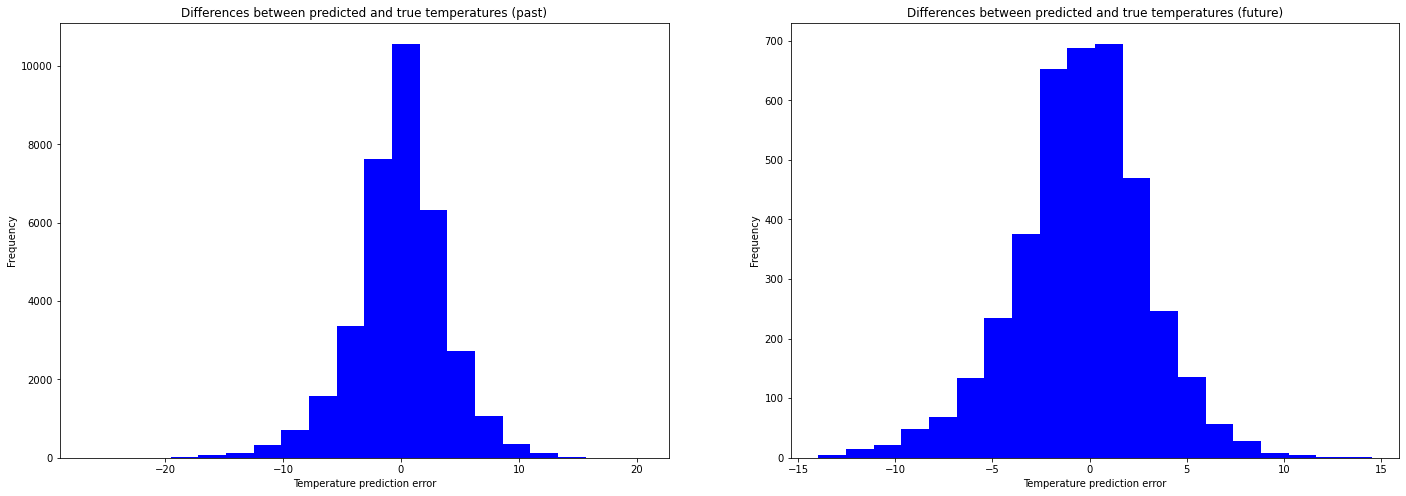

In [286]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

# Past
past_data_pred_y = past_data_pred_y[1:] # I delete the first datapoint because the model makes very bad predictions and change the range of the plot
past_data_true_y = past_data_true_y[1:]

differences_past = np.array(past_data_pred_y) - np.array(past_data_true_y)

axes[0].hist(differences_past, bins=20, color='blue')
axes[0].set_xlabel("Temperature prediction error")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Differences between predicted and true temperatures (past)")

# Future
differences_future = np.array(predicted_y) - np.array(true_y)

axes[1].hist(differences_future, bins=20, color='blue')
axes[1].set_xlabel("Temperature prediction error")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Differences between predicted and true temperatures (future)")

plt.show()

In [287]:
# Save data for later plot
past_data_pred_y2 = past_data_pred_y[1:]
past_data_true_y2 = past_data_true_y[1:]
future_data_pred_y2 = predicted_y
future_data_true_y2 = true_y

### Hoeffding Tree Regressor

In [288]:
from river.tree import HoeffdingTreeRegressor
from river import linear_model
from river.linear_model import LinearRegression
from river.compose import Pipeline
from river import optim
from river.preprocessing import OneHotEncoder, TargetStandardScaler
from river import neighbors
# Loading the data
dataset = stream.iter_csv(
    "dataset.csv", 
    converters = {
        'temperature': float, 
        'humidity':float, 
        'pressure':float, 
        'wind_direction':float, 
        'wind_speed':float, 
        'year': int, 
        'hour':int,
        'month':int
        },
    target='temperature'
    )
data = [(sample, target) for sample, target in dataset] # Storing fully in memory may not be the best solution and breaks a little the stream concept? 

# Preparing the model
model = Pipeline(
    OneHotEncoder('weather_description'),
    HoeffdingTreeRegressor(grace_period=250)
)

model = preprocessing.TargetStandardScaler(regressor=model)


# Training simulation a past data and a present stream

past_data_pred_y = []
past_data_true_y = []
# Past
for xi, yi in data[:35000]:
    y_pred = model.predict_one(xi)
    model.learn_one(xi, yi)
    # metric.update(xi,y_pred)
    past_data_pred_y.append(y_pred)
    past_data_true_y.append(yi)
    
# Present
stream_data = iter(data[35000:])
predicted_y = []
true_y = []
prev_xi, prev_yi = data[35000][0],data[35000][1]
for xi, yi in stream_data:
    try:
        y_pred = model.predict_one(xi) # Actual prediction for the next hour
        print(f"( {xi['year']}-{xi['month']} | {xi['hour']}:00 ) : Predicted temperature for next hour: {y_pred}")
        next_xi, next_yi = next(stream_data) # True temperature for the next hour
        print(f"( {xi['year']}-{xi['month']} | {xi['hour']}:00 ) : Actual temperature after one hour: {next_yi}")
        model.learn_one(xi, yi) 
        prev_xi, prev_yi = xi, yi 
        
        predicted_y.append(y_pred)
        true_y.append(next_yi)
        
    except StopIteration as err:
        print("End of data")
        break

( 2017-1 | 20:00 ) : Predicted temperature for next hour: 292.01284038625914
( 2017-1 | 20:00 ) : Actual temperature after one hour: 287.88
( 2017-1 | 22:00 ) : Predicted temperature for next hour: 291.8607685571222
( 2017-1 | 22:00 ) : Actual temperature after one hour: 289.21
( 2017-1 | 0:00 ) : Predicted temperature for next hour: 291.2055008425752
( 2017-1 | 0:00 ) : Actual temperature after one hour: 288.88
( 2017-1 | 2:00 ) : Predicted temperature for next hour: 288.9243346628821
( 2017-1 | 2:00 ) : Actual temperature after one hour: 287.0
( 2017-1 | 4:00 ) : Predicted temperature for next hour: 287.5045394134942
( 2017-1 | 4:00 ) : Actual temperature after one hour: 286.27
( 2017-1 | 6:00 ) : Predicted temperature for next hour: 285.71279085950334
( 2017-1 | 6:00 ) : Actual temperature after one hour: 285.89
( 2017-1 | 8:00 ) : Predicted temperature for next hour: 285.08708541006746
( 2017-1 | 8:00 ) : Actual temperature after one hour: 285.23
( 2017-1 | 10:00 ) : Predicted temp

In [289]:
from river import metrics

metric = utils.Rolling(metrics.MAE(),1)
metric2 = utils.Rolling(metrics.MSE(),1)

for y_pred, y_true in zip(predicted_y, true_y):
    metric.update(y_true, y_pred)
    metric2.update(y_true, y_pred)

print(f"MAE: {metric.get()}")
print(f"MSE: {metric2.get()}")


MAE: 0.2540663147356099
MSE: 0.064549692283334


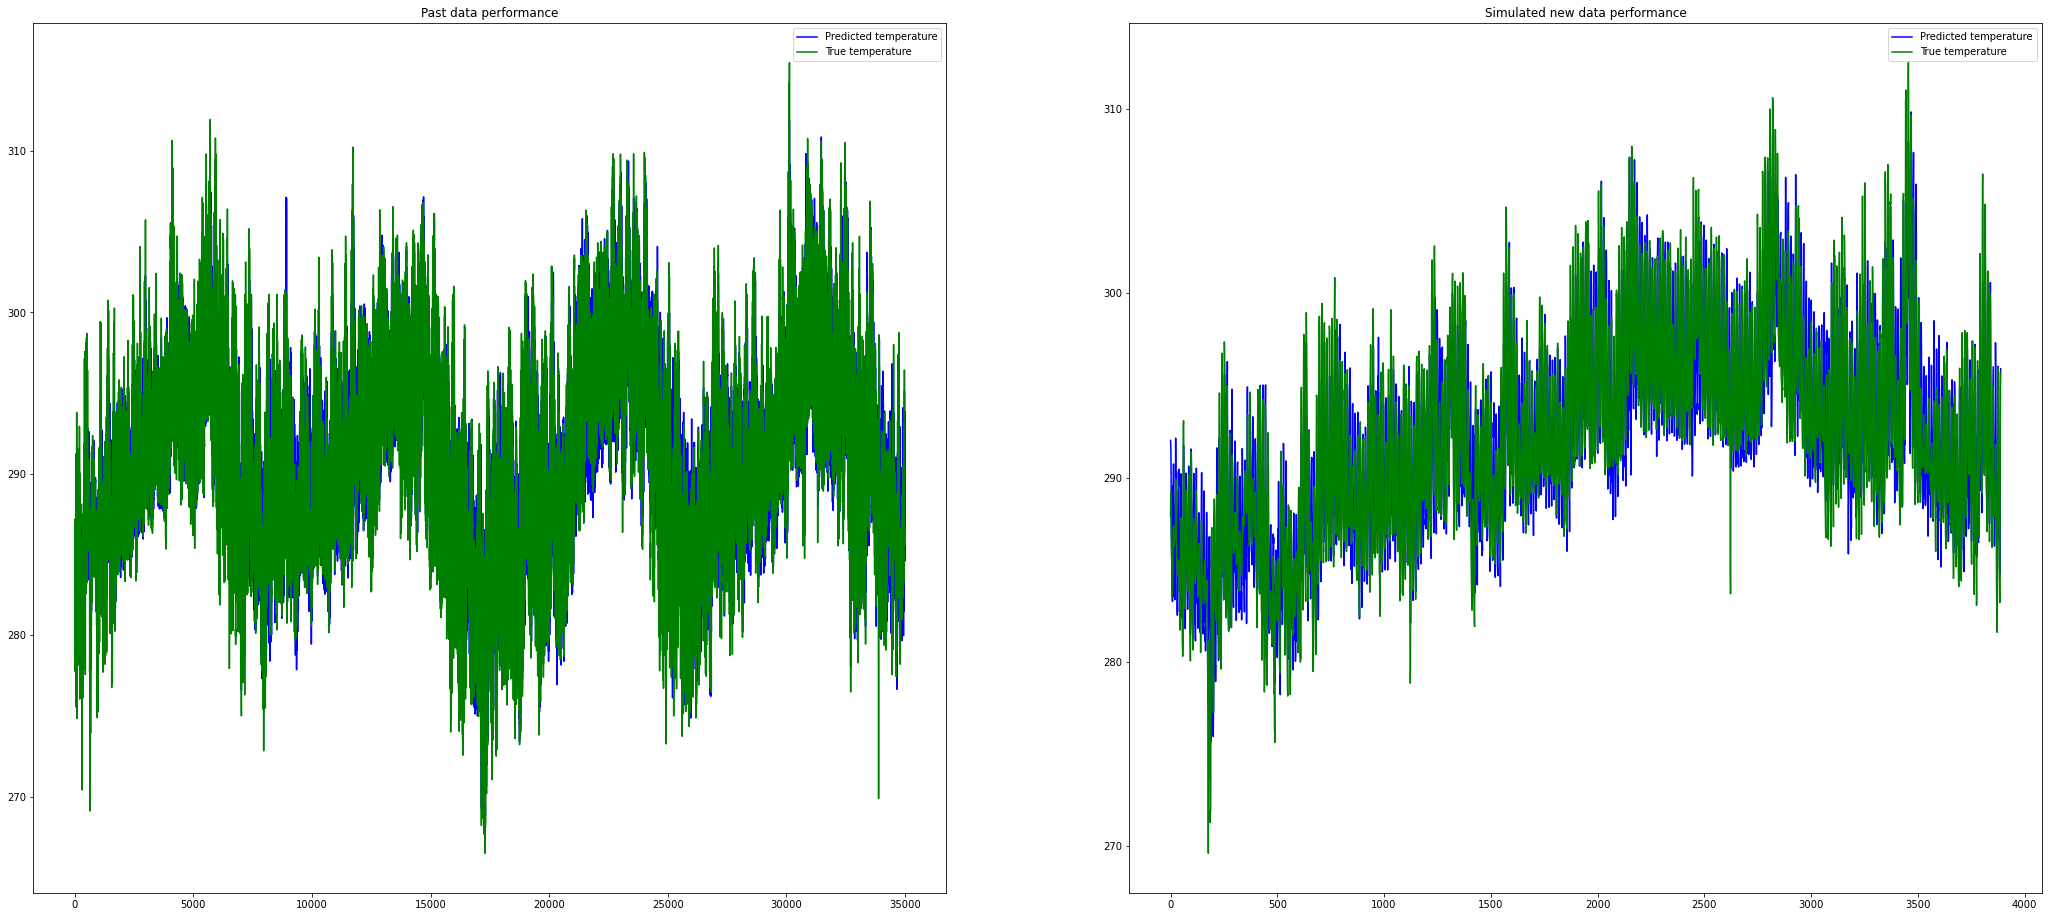

In [290]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(36, 16))
# Past
past_data_pred_y = past_data_pred_y[1:]
past_data_true_y = past_data_true_y[1:]
axes[0].plot(np.array(past_data_pred_y), color='blue', label='Predicted temperature')
axes[0].plot(np.array(past_data_true_y), color='green', label='True temperature')
axes[0].set_title("Past data performance")
axes[0].legend()
# Future
axes[1].plot(np.array(predicted_y), color='blue', label='Predicted temperature')
axes[1].plot(np.array(true_y), color='green', label='True temperature')
axes[1].set_title("Simulated new data performance")
axes[1].legend()

plt.show()

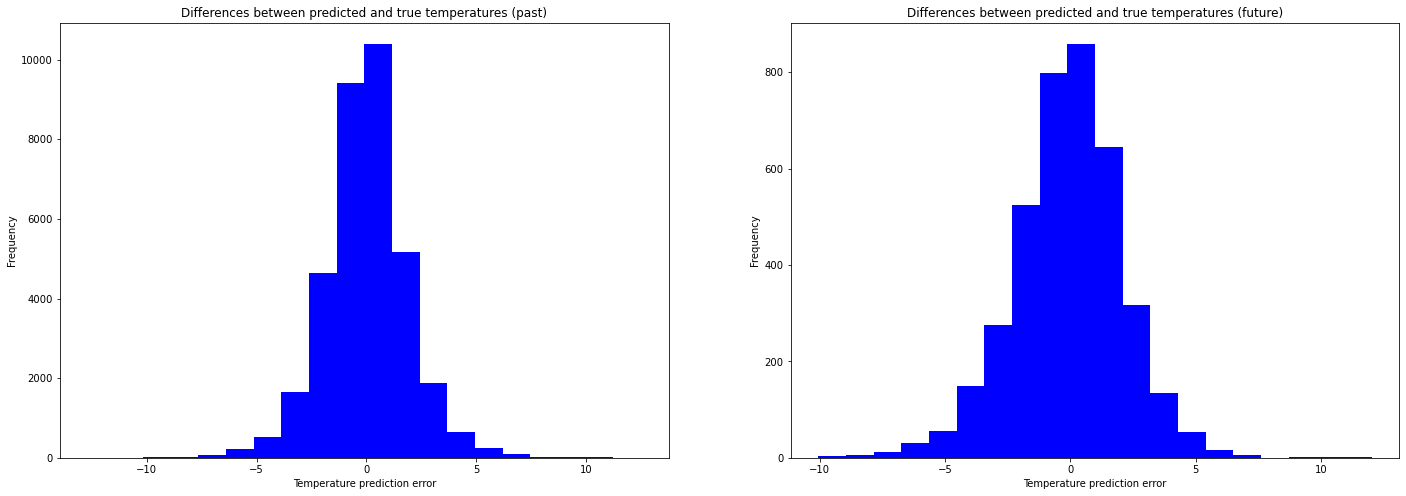

In [291]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

# Past
past_data_pred_y = past_data_pred_y[1:] # I delete the first datapoint because the model makes very bad predictions and change the range of the plot
past_data_true_y = past_data_true_y[1:]

differences_past = np.array(past_data_pred_y) - np.array(past_data_true_y)

axes[0].hist(differences_past, bins=20, color='blue')
axes[0].set_xlabel("Temperature prediction error")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Differences between predicted and true temperatures (past)")

# Future
differences_future = np.array(predicted_y) - np.array(true_y)

axes[1].hist(differences_future, bins=20, color='blue')
axes[1].set_xlabel("Temperature prediction error")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Differences between predicted and true temperatures (future)")

plt.show()

In [292]:
# Save data for later plot
past_data_pred_y3 = past_data_pred_y[1:]
past_data_true_y3 = past_data_true_y[1:]
future_data_pred_y3 = predicted_y
future_data_true_y3 = true_y


### Comparing models

In [293]:
import matplotlib.pyplot as plt
import numpy as np
from river import metrics

mae_scores = []
mse_scores = []

for pred, true in zip([future_data_pred_y1, future_data_pred_y2, future_data_pred_y3],
                      [future_data_true_y1, future_data_true_y2, future_data_true_y3]):

    metric = utils.Rolling(metrics.MAE(),1)
    metric2 = utils.Rolling(metrics.MSE(),1)

    for y_pred, y_true in zip(pred, true):
        metric.update(y_true, y_pred)
        metric2.update(y_true, y_pred)

    mae_scores.append(metric.get())
    mse_scores.append(metric2.get())


In [294]:
mae_scores

[0.6330003233659909, 2.0204905854192248, 0.2540663147356099]

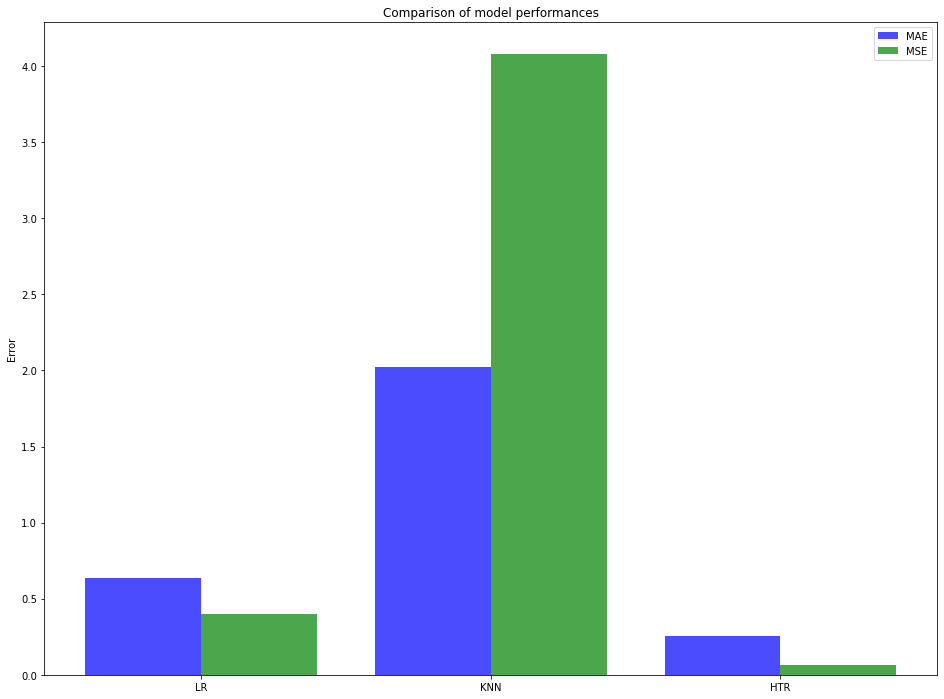

In [296]:
fig, ax = plt.subplots(figsize=(16, 12))
x_labels = ['LR', 'KNN', 'HTR']
x_pos = np.arange(len(x_labels))

ax.bar(x_pos - 0.2, mae_scores, width=0.4, color='blue', alpha=0.7, label='MAE')
ax.bar(x_pos + 0.2, mse_scores, width=0.4, color='green', alpha=0.7, label='MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_ylabel('Error')
ax.set_title('Comparison of model performances')
ax.legend()

plt.show()


As can be seen, Hoeffding Tree Regressor gives us the lowest error and KNN the worst. So in the last part of this project, we are gonna use this model for further predictions.

# Model optimization

Model's parameters can be found at: https://riverml.xyz/dev/api/tree/HoeffdingTreeRegressor/

Lets make first a Grid search optimization using River expand_param_grid function from utils package (https://riverml.xyz/dev/api/utils/expand-param-grid/)

For this scope, I will try to optimize two parameters:
- grace_period : Number of instances a leaf should observe between split attempts.
- leaf_prediction : Prediction mechanism used at leafs

In [298]:
from river.tree import HoeffdingTreeRegressor
from river.compose import Pipeline
from river import optim, utils
from river.preprocessing import OneHotEncoder, TargetStandardScaler

# Loading the data
dataset = stream.iter_csv(
    "dataset.csv", 
    converters = {
        'temperature': float, 
        'humidity':float, 
        'pressure':float, 
        'wind_direction':float, 
        'wind_speed':float, 
        'year': int, 
        'hour':int,
        'month':int
        },
    target='temperature'
    )
data = [(sample, target) for sample, target in dataset] 

# Preparing the model

model = Pipeline(
    OneHotEncoder('weather_description'),
    HoeffdingTreeRegressor()
)

param_grid = {
    'HoeffdingTreeRegressor': {
        'grace_period': [100, 200, 250, 500],
        'leaf_prediction' : ['mean','model','adaptive']
    }
}

models = utils.expand_param_grid(model, param_grid)

len(models)

12

To do this I take the previous code for training the model and iterate throught the possible models, saving the score of the best one and all the models in a dict for later use.

In [314]:
from river.metrics import MAE

past_data_pred_y = []
past_data_true_y = []
best_model = None
best_score = float('inf')

# Past
for xi, yi in data[:35000]:
    y_pred = model.predict_one(xi)
    model.learn_one(xi, yi)
    past_data_pred_y.append(y_pred)
    past_data_true_y.append(yi)
    metric.update(yi, y_pred)

# Lets iterate throught the models and select the one with the best MAE
for m in models:
    metric = utils.Rolling(metrics.MAE(),1)

    stream_data = iter(data[35000:])
    predicted_y = []
    true_y = []
    model = m

    for xi, yi in stream_data:
        try:
            y_pred = model.predict_one(xi)
            next_xi, next_yi = next(stream_data)
            model.learn_one(xi, yi)
            predicted_y.append(y_pred)
            true_y.append(next_yi)
            metric.update(next_yi, y_pred)
        except StopIteration:
            break

    model_score = metric.get()
    if model_score < best_score:
        best_model = m
        best_score = model_score
        best_predicted_y = predicted_y
        best_true_y = true_y


print(f'Best score: {best_score}')


Best score: 0.08408877165140893


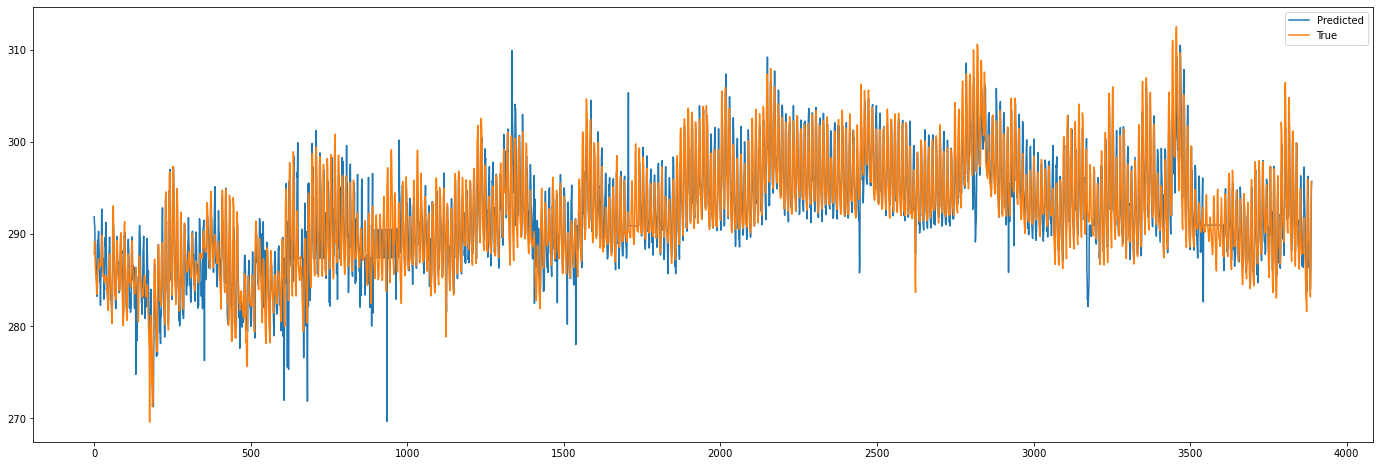

In [317]:
# Plotting best model
plt.figure(figsize=(24,8))
plt.plot(best_predicted_y, label='Predicted')
plt.plot(best_true_y, label='True')
plt.legend()
plt.show()

In [318]:
# Print the best model and its hyperparameters
if best_model is not None:
    ht = best_model[-1]
    params = ht.summary
    print(f"Best model hyperparameters: {params}")


Best model hyperparameters: {'n_nodes': 11, 'n_branches': 5, 'n_leaves': 6, 'n_active_leaves': 6, 'n_inactive_leaves': 0, 'height': 6, 'total_observed_weight': 116667.0}


In [324]:
if best_model is not None:
    grace = best_model[-1].grace_period # its a pipeline, so its needed to take the last element (the regressor)
    lp = best_model[-1].leaf_prediction
    print(f"Optimal grace period from the selected: {ht}")
    print(f"Optimal leaf prediction mode from the selected: {lp}")


Optimal grace period from the selected: 500
Optimal leaf prediction mode from the selected: adaptive


Nice! Now we have a much better error rate. 

# Testing the model with real time data

The dataset was made by fetching data from the OpenWeatherMap API (https://openweathermap.org/api), so lets register and get an API key.

In [1]:
API_KEY = ""

In [352]:
import requests

CITY = "Los Angeles"
url = f"https://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
else:
    print(f"Error {response.status_code} - {response.text}")
    
# Get datetime data
import datetime
now = datetime.datetime.now()
month = now.month
year = now.year
hour = now.hour

In [353]:
data

{'coord': {'lon': -118.2437, 'lat': 34.0522},
 'weather': [{'id': 800,
   'main': 'Clear',
   'description': 'clear sky',
   'icon': '01n'}],
 'base': 'stations',
 'main': {'temp': 9.08,
  'feels_like': 8.07,
  'temp_min': 6.99,
  'temp_max': 11.06,
  'pressure': 1024,
  'humidity': 76},
 'visibility': 10000,
 'wind': {'speed': 2.06, 'deg': 210},
 'clouds': {'all': 0},
 'dt': 1677467362,
 'sys': {'type': 1,
  'id': 3694,
  'country': 'US',
  'sunrise': 1677421545,
  'sunset': 1677462382},
 'timezone': -28800,
 'id': 5368361,
 'name': 'Los Angeles',
 'cod': 200}

Nice! We have the data, lets filter it to fetch the features we need.

In [354]:
pressure = data["main"]["pressure"]
humidity = data["main"]["humidity"]
temperature = data["main"]["temp"]
wind_speed = data["wind"]["speed"]
wind_degree = data["wind"]["deg"]
weather_description = data["weather"][0]["description"]

print(f"Pressure: {pressure} - Humidity: {humidity} - Wind Speed: {wind_speed} - Wind Direction: {wind_degree} - Description: {weather_description} - Temperature: {temperature}")
print(f"Year: {year} - Month: {month} - Hour: {hour} ")

Pressure: 1024 - Humidity: 76 - Wind Speed: 2.06 - Wind Direction: 210 - Description: clear sky - Temperature: 9.08
Year: 2023 - Month: 2 - Hour: 4 


Good and bad news. We have the data, but is slightly different from the data we used before. Some things can be easily transformed, like temperature to kelvin:

In [340]:
temperature = temperature + 273.15
temperature

282.76

But the weather description field will be a pain since the dataset use different cathegories from the actual ones retrieved using the API. Instead of transforming the cathegories, lets try a simple approach just retraining a model without this feature and use it to make the predictions.

Now we know that the best hyperparameters from the ones tested with HT Regressor are:
- Optimal grace period from the selected: 500
- Optimal leaf prediction mode from the selected: adaptive

So lets use them. When iterating the csv, we can ignore also the weather_description field using the "drop" parameter. When I created the dataset I created another one without that field so lets use it.

In [346]:
from river import linear_model
from river.linear_model import LinearRegression
from river.compose import Pipeline
from river import optim
from river.preprocessing import OneHotEncoder, TargetStandardScaler

# "datasetmod.csv" file is just the dataset without weather_description field
# I deleted the code, but can be removed manually in any case  
dataset = stream.iter_csv(
    "datasetmod.csv", 
    converters = {
        'temperature': float, 
        'humidity':float, 
        'pressure':float, 
        'wind_direction':float, 
        'wind_speed':float, 
        'year': int, 
        'hour':int,
        'month':int
        },
    target='temperature'
    )
data = [(sample, target) for sample, target in dataset] # Storing fully in memory may not be the best solution and breaks a little the stream concept? 


model = Pipeline(
    HoeffdingTreeRegressor(grace_period=500, leaf_prediction='adaptive')
)
model = preprocessing.TargetStandardScaler(regressor=model)

# Training 
past_data_pred_y = []
past_data_true_y = []

metric = utils.Rolling(metrics.MAE(),1)
metric2 = utils.Rolling(metrics.MSE(),1)

print(evaluate.progressive_val_score(data, model, metric))
print(evaluate.progressive_val_score(data, model, metric2))    


MAE: 1.354585
MSE: 6.831733


Pretty pour results without the weather_description field. But lets use it anyway by now to make a prediction:

In [364]:
type(month)

int

In [374]:
new_data = {
    'humidity' : float(humidity),
    'pressure' : float(pressure),
    'wind_direction' : float(wind_degree),
    'wind_speed' : float(wind_speed),
    'year' : int(year),
    'hour' : int(hour),
    'month' : int(month)
}


pred = model.predict_one(new_data)
print(pred)

289.80481819727913


So, the predicted temperature is 289.80 (in Kelvin, 16.65ºC) with an error of 1.35. Its not a good model, but its a starting point.

# Conclussions

Throughout the present work, different weather prediction models have been studied using the River library for Python. Of the three models used, the Hoeffding Trees have proved to be a fairly accurate regression model in this context. However, the accuracy of this model is greatly reduced by not having the sky description at the time of training and descriptions. 

Finally, although the temperature prediction has been used as an example to simplify the proposed exercise, it would be interesting to also look for other datasets and study how the same temperature or some other variable influences other fields, such as (following the line of what was described by the dataset creator), the use of bicycles or criminality. 